In [4]:
import numpy as np
!pip -q install transformers
!pip -q install emoji

In [5]:
import scipy 
import regex 
import emoji 
import re

In [6]:
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [7]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [8]:
print('Tokenized: ', tokenizer.tokenize("I am happy"))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize("I am happy")))

Tokenized:  ['i', 'am', 'happy']
Token IDs:  [1045, 2572, 3407]


In [46]:
################################################
#########
#########    CODE TO CLEAN DATA
#########
################################################


def get_words(post):
    split_l = post.split(" ")
    tmp_list = ' '.join(split_l).split()
    normd = [ww.lower() for ww in tmp_list]
    return normd

def make_lower(word):
    return word.lower()

def remove_links(post):
    url_pattern = re.compile(r'https?//\S+|www\.\S+')
    return url_pattern.sub(r'', post)
    
def remove_bad_chars(post):
    other_chars = ['*', '[', ']', '; ',":","“","“","”","-","=","|","^"] 
    for char in other_chars:
        post = post.replace(char, '')
    return post

def train_test_split(df, frac=0.2):   
    # get random sample 
    test = df.sample(frac=frac, axis=0)
    # get everything but the test sample
    train = df.drop(index=test.index)

    return train, test

def get_processed_data(data, as_list=False, split=0.10):
    data.dropna(subset=['body'], inplace=True)
    data=data.reset_index()
    
    # remove bad characters
    data["body"]=data["body"].apply(remove_bad_chars)
    data["title"]=data["title"].apply(remove_bad_chars)
    
    # remove all links present in a post title and body
    data["body"]=data["body"].apply(remove_links)
    data["title"]=data["title"].apply(remove_links)
    
    data["body"]=data["body"].apply(make_lower)
    data["title"]=data["title"].apply(make_lower)
    
    # put posts into list of words
    if as_list:
        print("Converting string to list of strings")
        data["body"]=data["body"].apply(get_words)
        data["title"]=data["title"].apply(get_words)
    else:
        data["body"]=data["body"].apply(make_lower)
        data["title"]=data["title"].apply(make_lower)
        
    data_train, data_test = train_test_split(data,frac=split)

        
    return data_train, data_test, data

def convert_to_dict(data,col):
    my_dict = {}
    for index, row in data.iterrows():
        my_dict[index] = row[col]
    return my_dict


In [10]:
def extract_emojis(input_file):
    emoji_list = []
    emoji_mat = {}
    posts = input_file.readlines()
    for line in posts:
        post = line[0]
        data = regex.findall(r'\X', post)
        for word in data:
            if any(char in emoji.EMOJI_DATA for char in word):
                if word not in emoji_list:
                    emoji_list.append(word)
    
    for key in emoji_list:
        emoji_mat[key] = np.zeros(len(posts)-1)

    i = 0
    for line in posts:
        post = line[0]
        data = regex.findall(r'\X', post)
        for word in data:
            for char in word:
                if emoji_mat.get(char) is not None:
                    emoji_mat[char][i] += 1
        i += 1
    return emoji_mat

In [50]:
# Run preprocessing code
def preprocess(f_in,to_list=False):
    #print("[preprocess::extract emojis]")
    #f = open(f_in, "r")
    #my_dict_emoji = extract_emojis(f)

    # open and process
    print("[preprocess::extract titles and body]")
    data = pd.read_csv(f_in)
    processed_train, processed_test, processed_all =get_processed_data(data,as_list=to_list)
        
    my_dict_titles_train = convert_to_dict(processed_train,"title")
    my_dict_body_train = convert_to_dict(processed_train,"body")
    
    my_dict_titles_test = convert_to_dict(processed_test,"title")
    my_dict_body_test = convert_to_dict(processed_test,"body")
    
    my_dict_titles_all = convert_to_dict(processed_all,"title")
    
    print("[preprocess::complete]")
    #return my_dict_emoji,my_dict_titles, my_dict_body, processed
    return my_dict_titles_train, my_dict_body_train, processed_train, my_dict_titles_test, my_dict_body_test, processed_test, my_dict_titles_all, processed_all 

In [51]:
#######
#######
####### LOAD DATA HERE
#######
#######

import pandas as pd
from google.cloud import storage
from io import BytesIO
client = storage.Client()
bucket_name = "my_processed_data_bucket"
file_name = "text_and_label.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()

dict_titles_train, dict_body_train, processed_train, dict_titles_test, dict_body_test, processed_test, my_dict_titles_all, processed_all  = preprocess(BytesIO(content))
vader_labels_train = list(processed_train["label"])

[preprocess::extract titles and body]
[preprocess::complete]


In [55]:
# SET THE LABELS FROM WORDS TO INTEGERS
labels_train = []
# likely need to change later?
#  converts hold -> 0, sell -> 1, and buy -> 2
for ll in vader_labels_train:
    if ll == "Neutral":
        labels_train.append(0)
    elif ll == "Positive":
        labels_train.append(1)
    elif ll == "Negative":
        labels_train.append(2)

vader_labels_test = list(processed_test["label"])
labels_test = []
for ll in vader_labels_test:
    if ll == "Neutral":
        labels_test.append(0)
    elif ll == "Positive":
        labels_test.append(1)
    elif ll == "Negative":
        labels_test.append(2)
        
labels_all = []
vader_labels_all = list(processed_all["label"])
for ll in vader_labels_all:
    if ll == "Neutral":
        labels_all.append(0)
    elif ll == "Positive":
        labels_all.append(1)
    elif ll == "Negative":
        labels_all.append(2)

In [14]:
# GET SENTENCES 
sentences_train = list(dict_titles_train.values())
#print(sentences)
#sentences = sentences[100:420]
print(sentences_train[50])
# make fake labels for now 
#labels = [1 for ss in sentences]

an open letter to melvin capital, cnbc, boomers, and wsb


In [15]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
#################
#####
#####    TRAINING DATA ONLY

input_ids = []
attention_masks = []

sentences = sentences_train
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_train)

# Print sentence 0, now as a list of IDs.
#print('Original: ', sentences[0])
#print('Token IDs:', input_ids[0])

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [16]:
# set up training and testing
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

20,037 training samples
2,227 validation samples


In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
params = list(model.named_parameters())

In [21]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, setting notebook to 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [22]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, at first but it takes about 18 minutes - so revised to 1 for analysis turn around.
# Likely will settle on 2
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [23]:
# Prediction on test set
'''
# Set the batch size.  
batch_size = 10

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()
'''

"\n# Set the batch size.  \nbatch_size = 10\n\n# Create the DataLoader.\nprediction_data = TensorDataset(input_ids, attention_masks, labels)\nprediction_sampler = SequentialSampler(prediction_data)\nprediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)\n\nprint('Predicting labels for {:,} test sentences...'.format(len(input_ids)))\n\n# Put model in evaluation mode\nmodel.eval()\n"

In [24]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [25]:
import random
import numpy as np


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

In [26]:
############################################
############################################
############################################
##
##           TRAINING 

import random


seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  



======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,253.    Elapsed: 0:00:48.
  Batch    80  of  1,253.    Elapsed: 0:01:21.
  Batch   120  of  1,253.    Elapsed: 0:01:54.
  Batch   160  of  1,253.    Elapsed: 0:02:27.
  Batch   200  of  1,253.    Elapsed: 0:03:01.
  Batch   240  of  1,253.    Elapsed: 0:03:34.
  Batch   280  of  1,253.    Elapsed: 0:04:07.
  Batch   320  of  1,253.    Elapsed: 0:04:40.
  Batch   360  of  1,253.    Elapsed: 0:05:13.
  Batch   400  of  1,253.    Elapsed: 0:05:46.
  Batch   440  of  1,253.    Elapsed: 0:06:19.
  Batch   480  of  1,253.    Elapsed: 0:06:53.
  Batch   520  of  1,253.    Elapsed: 0:07:26.
  Batch   560  of  1,253.    Elapsed: 0:07:59.
  Batch   600  of  1,253.    Elapsed: 0:08:32.
  Batch   640  of  1,253.    Elapsed: 0:09:05.
  Batch   680  of  1,253.    Elapsed: 0:09:38.
  Batch   720  of  1,253.    Elapsed: 0:10:12.
  Batch   760  of  1,253.    Elapsed: 0:10:45.
  Batch   800  of  1,253.    Elapsed: 0:11:18.
  Batch   840  of

In [27]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.48,0.35,0.88,0:17:33,0:00:37
2,0.21,0.31,0.91,0:17:18,0:00:37


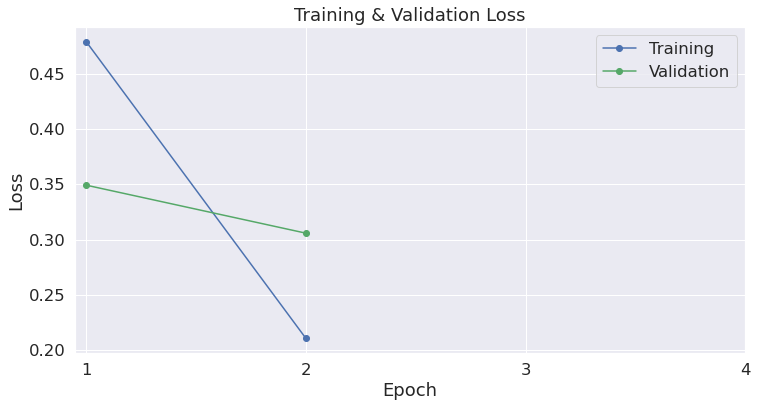

In [28]:
import matplotlib.pyplot as plt


import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [29]:
import pandas as pd

# Create sentence and label lists FROM TESTING DATA


sentences_test = list(dict_titles_test.values())
#print(sentences)
#sentences = sentences[100:420]
print(sentences_test[50])
# make fake labels for now 
#labels = [1 for ss in sentences]

##### SET SENTENCES_TEST to SENTENCES

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

sentences = sentences_test

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,          # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_test)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


listen up, retards!


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,474 test sentences...
    DONE.


In [31]:
print("Now determine accuracy ")

Now determine accuracy 


In [32]:
label_0 = []
label_1 = []
label_2 = []
correct_label=0
pred_list = []
tru_list = []

for ii, ll in enumerate(predictions):
    pred_labels_i = np.argmax(ll, axis=1).flatten()
    #print(pred_labels_i)
    for ee in pred_labels_i:
        pred_list.append(ee)
        

for ii, ll in enumerate(true_labels):
    true_labels_i = ll # np.argmax(ll, axis=1).flatten()
    #print(true_labels_i)
    for tt in true_labels_i:
        tru_list.append(tt)

for jj, pp in enumerate(pred_list):
    #print(pp)
    #print(tru_list[ii])
    if pp == tru_list[jj]:
        correct_label+=1
print("Correctly labeled {}".format(correct_label))

Correctly labeled 2295


In [33]:
print(" Fraction Correct {0}".format(correct_label/len(input_ids)))

 Fraction Correct 0.9276475343573161


In [ ]:
# now get the sentiment for every post and write it out into a text file 

In [56]:
# Create sentence and label lists FROM ALL DATA TO THEN WRITE OUT AND SAVE

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
all_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = RandomSampler(dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

sentences_all = list(my_dict_titles_all.values())
print(len(sentences_all))
#sentences = sentences[100:420]
print(sentences_all[50])
# make fake labels for now 
#labels = [1 for ss in sentences]

##### SET SENTENCES_TEST to SENTENCES

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

sentences = sentences_all

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,          # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_all)

# Set the batch size.  
batch_size = 16

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

24738
gme wars suits strike back. warning for all you fellow autists


In [57]:
print('Predicting labels for {:,} ALL sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('  DONE.')

Predicting labels for 24,738 ALL sentences...
    DONE.


In [59]:
final_pred = []

for ii, ll in enumerate(predictions):
    pred_labels_i = np.argmax(ll, axis=1).flatten()
    #print(pred_labels_i)
    for ee in pred_labels_i:
        final_pred.append(ee)

f_out = open("./src/bert_predictions.txt","w")
for pp in final_pred:
    f_out.write("{0}\n".format(pp))
f_out.close()